## Аминокислотные последовательности антител

<img src="https://i0.wp.com/www.blopig.com/blog/wp-content/uploads/2013/07/Antibody1.png?ssl=1" style="background:white" width="600"/>

Как и любые белки́, [антитела](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%82%D0%B8%D1%82%D0%B5%D0%BB%D0%B0) состоят из [аминокислот](https://shorturl.at/Wc6V4), соединённых пептидными связями.

Каждой аминокислоте соответствует однобуквенный код (A - аланин, C - цистеин, D - аспартат, и т.д.), поэтому мы можем компактно записывать первичную структуру белков (то есть просто цепочку аминокислот) в виде строк.

Сегодня нам предстоит решить две задачи:
1. Обучить модель-классификатор, позволяющую по аминокислотной последовательности понять, из какого животного было получено антитело
2. Обучить модель-генератор новых антител с условием на биологический вид

#### Подготовим данные

В нашем наборе данных присутствуют антитела (точнее - небольшие фрагменты тяжелых цепей антител, VH-домены, непосредственно участвующие в связывании инородных молекул - антигенов), полученные из образцов пяти биологических видов: человек, макака-резус, мышь, кролик и верблюд.

In [130]:
import pandas as pd

antibodies = pd.read_csv("antibodies.csv").sample(frac=1.0)
antibodies.head(10)

,sequence,species
3993,QVTLKESGPALVTPTQTLTLTCTFSGFSLSTSGMRVSWIRQPPGKA...,Rhesus
3737,QMQLQESGPGPVTPSETLSLTCAVSGASTRSFCWGWTRQSPGNGLE...,Rhesus
2870,SVKVSCKASGYTFTSYYIHWVRQAPGQGLEWMGMINPSAGITTYAQ...,Mouse
558,QVQLQQPGAELVMPGASVKLSCKASGYTFTSYWMHWVKQRPGQGLE...,Human
3197,QLQLQESGPGLVKPSENLSLTCAVSGGSIRSNWWSWIRPHPGKGLE...,Rhesus
1694,HVQLVESGGGSVQAGGSLRLSCAVSGYTRSPYCMGWFRQAPGKERE...,Camel
2317,SVKVSCKASGYTFTVSFIHWVRQAPGHGLEWVGMIDPSRGASQSAV...,Mouse
4774,QEQLVESGGGLVQPEGSLTLTCTASGFSFSSSYFMCWVRQAPGKGL...,Rabbit
3344,QLQLQESGPGLVKPSETLSLTCAVSCGSISSGYGWSWFRQPPGKGL...,Rhesus
2993,SVKVSCKASGYTFSSHAMHWVRQAPGQRLEWMGWINADNGNTKYSQ...,Mouse


Создадим словари для аминокислот, специальных токенов и биологических видов:

In [131]:
SPECIAL_TOKENS = "_?\n"
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWYX"
VOCAB = {char: i for i, char in enumerate(SPECIAL_TOKENS + AMINO_ACIDS)}
SPECIES = {name: i for i, name in enumerate(sorted(antibodies["species"].unique()))}
SPECIES

{'Camel': 0, 'Human': 1, 'Mouse': 2, 'Rabbit': 3, 'Rhesus': 4}

In [132]:
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from typing import Type


#torch.manual_seed(42)
class AntibodiesDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.sequences = [
            [1] + [VOCAB[char] for char in s] + [2] for s in df["sequence"]
        ]
        self.labels = [SPECIES[label] for label in df["species"]]

    def __getitem__(self, index: int) -> tuple[list[int], int]:
        return self.sequences[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.sequences)

    @property
    def vocab_size(self) -> int:
        return len(VOCAB) # Сколько символов ----------------------------------------------------------------------------------------------------------------------------


        
    @staticmethod
    def collate_fn(batch: list[tuple[list[int], int]]) -> tuple[Tensor, Tensor]:
        encoded, lang_ids = zip(*batch)
        max_len = max(map(len, encoded))
        x = torch.zeros((len(encoded), max_len), dtype=int)
        for i, seq in enumerate(encoded):
            x[i, : len(seq)] = torch.tensor(seq)

        return x, torch.tensor(list(lang_ids))


labels = sorted(antibodies["species"].unique())
dataset = AntibodiesDataset(antibodies)
train_dataset, test_dataset = random_split(
    dataset, [4500, 500], torch.Generator().manual_seed(42)
)
print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

Train size:  4500
Test size:  500


In [133]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=dataset.collate_fn
)

#### Задание 1 (6 баллов). Классификация антител по биологическим видам

Мы начнём с нашей рекуррентной ячейки с последней практики:

In [134]:
class RNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        h = torch.cat([x, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

**1.1. (1 балл)** Реализуйте архитектуру модели, которая по входной последовательности будет давать вероятностное распределение над биологическими видами.
Она даже немного проще, чем модель для генерации: линейный блок-классификатор мы применяем только к последнему скрытому состоянию (когда вся последовательность обработана).

**1.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики точности классифкации для обучающей и тестовой выборок.

**1.3. (3 балла)** Реализуйте другой вид рекуррентной ячейки (GRU или LSTM, см. практику), обучите модель на его основе, выведите графики точности. Как изменилась точность модели и скорость обучения?


Указание: используйте небольшие модели, с размером скрытого слоя 64

### Задание 1.1

In [135]:
class RNN(nn.Module):
    def __init__(
        self, block: Type[nn.Module], vocab_size: int, hidden_dim: int = 64, n_classes: int = 5
    ) -> None: 
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = block(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, n_classes)
        self.act = nn.ReLU()
       
    def forward(self, x: Tensor) -> Tensor: 
        B, T = x.shape
        x = self.embed(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, h)  # B x hidden
        out = self.act(self.fc1(h))
    
        # lm_head: B x T x hidden -> B x T x V
        return out.softmax(dim=1)

In [136]:
hidden_dim = 32
model = RNN(
    vocab_size=dataset.vocab_size, block=RNNCell,
    hidden_dim=hidden_dim,
)
tokens, labels = next(iter(train_loader))
model.forward(tokens).shape

torch.Size([32, 5])

In [137]:
import torchmetrics
import lightning as L
import torch
from torch import nn, optim
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from typing import cast

from lightning.pytorch.utilities.types import STEP_OUTPUT

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

class Lit(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=5)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=5)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = nn.functional.cross_entropy(probs, y)
        self.train_acc(probs, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = nn.functional.cross_entropy(probs, y)
        self.val_acc(probs, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


from aim.pytorch_lightning import AimLogger

model = RNN(vocab_size=len(VOCAB), hidden_dim=64,block=RNNCell, n_classes=5)

lit_module = Lit(model=model)

logger=AimLogger("logs", experiment='RNN11')

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    log_every_n_steps=10,
    enable_progress_bar=True,
    logger=logger
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Задание 1.2

In [138]:
trainer.fit(lit_module, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | RNN                | 10.2 K | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sachaiugai/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/sachaiugai/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


![title](07RNN1.png)

### Задание 1.3

In [139]:
class GRUCell(nn.Module):
   
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear_z = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.linear_r = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.linear_h = nn.Linear(input_dim + hidden_dim, hidden_dim)
        
    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        z = torch.cat([x, h], dim=1)
        z = self.linear_z(z)
        z = F.sigmoid(z)
        r = torch.cat([x, h], dim=1)
        r = self.linear_r(r)
        r = F.sigmoid(r)
        h_ = torch.cat([r * h, x], dim=1)
        h_ = self.linear_h(h_)
        h_ = F.tanh(h_)
        h = (1 - z) * h_ + z * h
        return h

In [140]:
hidden_dim = 64

modelGRU = RNN(
    vocab_size=dataset.vocab_size, block=GRUCell,
    hidden_dim=hidden_dim,
)
lit_moduleGRU = Lit(model=modelGRU)

loggerGRU=AimLogger("logs", experiment='GRU13')

trainerGRU = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    log_every_n_steps=10,
    enable_progress_bar=True,
    logger=loggerGRU
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [141]:
trainerGRU.fit(lit_moduleGRU, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | RNN                | 26.7 K | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
26.7 K    Trainable params
0         Non-trainable params
26.7 K    Total params
0.107     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sachaiugai/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/sachaiugai/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


![title](07GRU1.png)

#### Задание 2 (8 баллов + 4 бонусных). Генерация антител

Поиграем за B-лимфоцит и попробуем создать новые антитела.

Модель - почти полная копия модели с практики, но есть дополнительное условие: теперь кроме текущего токена и предыдущего скрытого состояния пусть наша ячейка принимает ещё метку биологического вида, к которому должно относиться антитело, вроде такого:

**2.1. (2 балла)** Реализуйте архитектуру модели для генерации антител символ за символом

**2.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики функции ошибки.

**2.3. (4 балла)** Сгенерируйте с помощью модели по 20 антител для каждого биологического вида в отдельных ячейках, выведите их в ноутбуке. Воспользуйтесь функцией `get_sequence_score` (ниже), чтобы посчитать сходство ваших антител с природными (вернее - очень грубую оценку). Посчитайте, сколько антител из сгенерированных вами имеют оценку 0.55 и выше для каждого биологического вида.

**2.4. (Бонус 4 балла)** Повторите пункты 2.2 и 2.3, но используйте другой тип рекуррентной ячейки (GRU или LSTM).


### Задание 2.1

In [147]:
class ConditionalRNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, class_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim+hidden_dim+class_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor, c: Tensor) -> Tensor:
        # x: B x input_dim: эмбеддинг последнего токен
        # c: B x class_dim: эмбеддинг биологического вида
        # h: B x hidden_dim: последнее скрытое состояние
        
    
        #print(c.shape, x.shape, h.shape)
        h = torch.cat([x, h, c], dim=1)
        h = self.linear(h)
        return F.tanh(h)

In [170]:
class ConditionalRNN(nn.Module):
    def __init__(self, vocab_size: int, block: Type[nn.Module], hidden_dim: int) -> None:
        super().__init__()
        self.embed_token = nn.Embedding(vocab_size, hidden_dim)
        self.embed_class = nn.Embedding(5, hidden_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = block(hidden_dim, hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x: Tensor, c: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape
        c = c.expand((B, T))
        x = self.embed_token(x)  # B x T x hidden_dim
        c =  self.embed_class(c)
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        logits = [] # T x B x V
        for t in range(T):
            xt = x[:, t, :]
            ct = c[:, t, :]
            h = self.rnn.forward(xt, h, ct)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x hidden
            logits.append(y)
            # save prediction for step t + 1

        # lm_head: B x T x hidden -> B x T x V
        return torch.cat(logits, dim=1)

In [171]:
hidden_dim = 64
tokens, labels = next(iter(train_loader))
model = ConditionalRNN(
    vocab_size=dataset.vocab_size,
    hidden_dim=hidden_dim, block=ConditionalRNNCell
)

In [172]:
@torch.no_grad()
def generate(model: ConditionalRNN, idx: Tensor, cls: Tensor, max_new_tokens: int) -> Tensor:
    # idx: B x T
    for t in range(max_new_tokens):
        logits = model.forward(idx, cls)[:, -1]  # B x T x V
        probs = F.softmax(logits, dim=1)  # B x V
        new_token = torch.multinomial(probs, 1)
        idx = torch.cat([idx, new_token], dim=1)

    return idx

In [173]:
VOCAB_ = {
        0: '_', 1: '?', 2: '\n', 3: 'A', 4: 'C', 5: 'D', 6: 'E', 7: 'F', 8: 'G', 9: 'H',
        10: 'I', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'P', 16: 'Q', 17: 'R', 18: 'S',
        19: 'T', 20: 'V', 21: 'W', 22: 'Y', 23: 'X'
    }

def batch_decode(out_tensor):
    def decode_string(tokens):
        decoded_strings = []
        for t in tokens:
            if t.item() in {0, 1}:
                continue
            elif t.item() == 2:
                break
            else:
                decoded_strings.append(VOCAB_.get(t.item(), '?'))
        return ''.join(decoded_strings)

    decoded_strings = [decode_string(t) for t in out_tensor]

    return decoded_strings

In [174]:
samples = generate(model, idx=torch.full(size=(4, 1), fill_value=1, dtype=int), cls=torch.zeros(4, 1).int(), max_new_tokens=40)
print('\n'.join(batch_decode(samples)))

SPDLWWEGTX
GRLWLEEIXERMHSKGVFGIQGKWRQHHV
FLVRWDASNFAGYEAKFQDERHTMVMQLAWTMYECDFL
LLWPXXCASPYE


### Задание 2.2

In [175]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
losses = []
for epoch in range(25):
    for tokens, _ in train_loader:
        logits = model.forward(tokens, _.view(-1, 1))  # B x T x V
        loss = F.cross_entropy(
            logits[:, :-1].reshape(-1, len(VOCAB)),
            tokens[:, 1:].reshape(-1),
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    losses.append(loss.item())
    print(epoch, loss)

0 tensor(1.9576, grad_fn=<NllLossBackward0>)
1 tensor(1.5370, grad_fn=<NllLossBackward0>)
2 tensor(1.2501, grad_fn=<NllLossBackward0>)
3 tensor(1.2862, grad_fn=<NllLossBackward0>)
4 tensor(1.1347, grad_fn=<NllLossBackward0>)
5 tensor(1.1095, grad_fn=<NllLossBackward0>)
6 tensor(1.0116, grad_fn=<NllLossBackward0>)
7 tensor(1.2413, grad_fn=<NllLossBackward0>)
8 tensor(1.0645, grad_fn=<NllLossBackward0>)
9 tensor(0.9579, grad_fn=<NllLossBackward0>)
10 tensor(0.8674, grad_fn=<NllLossBackward0>)
11 tensor(1.0708, grad_fn=<NllLossBackward0>)
12 tensor(0.9236, grad_fn=<NllLossBackward0>)
13 tensor(0.9317, grad_fn=<NllLossBackward0>)
14 tensor(1.0038, grad_fn=<NllLossBackward0>)
15 tensor(0.8670, grad_fn=<NllLossBackward0>)
16 tensor(0.9518, grad_fn=<NllLossBackward0>)
17 tensor(1.0125, grad_fn=<NllLossBackward0>)
18 tensor(0.8832, grad_fn=<NllLossBackward0>)
19 tensor(0.9657, grad_fn=<NllLossBackward0>)
20 tensor(1.0494, grad_fn=<NllLossBackward0>)
21 tensor(0.9495, grad_fn=<NllLossBackward0>

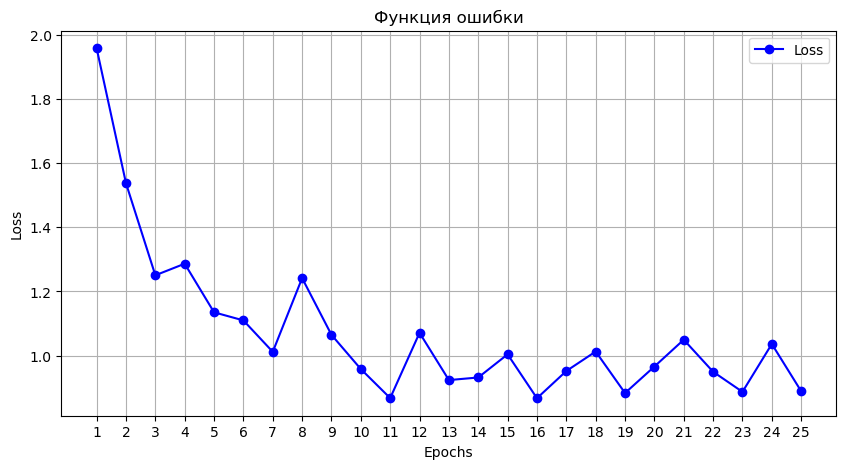

In [76]:
import matplotlib.pyplot as plt

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Функция ошибки')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.legend()
plt.show()

### Задание 2.3

In [55]:
! pip install biopython==1.84

In [77]:
from Bio.Align import PairwiseAligner


def get_sequence_score(query_sequence: str) -> float:
    references = [
        "QVQLQQPGAELVKPGASVKMSCKAS_WITWVKQRPGQGLEWIGDI_TNYNEKFKTKATLTVDTSSSTAYMQLSSLTSEDSAVYYCAR_WGQGTSVTVSS",
        "EVKLEESGGGLVQPGGSMKLSCAAS_WMDWVRQSPEKGLEWVAEI_TYYAESVKGRFTISRDDSKSSVYLQMNSLRAEDTGIYYCTA_WGQGTLVTVSA",
        "HVQLVESGGGSVQPGGSLRLSCTVS_CMGWFRRAPGKEREKVATL_TSYADSVKGRFAISQDPAKNTLWLQMNSLKPEDSATYYCAA_SSRGTQVTVS",
        "QVQLVESGGGSVQAGGSLKLSCAAS_CMGWSRQAPGKGREGVARI_TAYADSVKGRFTISHDSIKNTLYLQMNSLRPEDTAKYYCAA_WGQGTQVTV",
        "QSLEESGGDLVKPGASLTLTCTAS_YMCWVRQAPGKGLEWIACI_TYYASWAKGRFTISKTSSTTVTLQMTSLTAADTATYFCAS_WGQGTLVTVS",
        "QEQLVESGGGLVKPGASLTLTCKAS_VMCWVRQAPGKGLEWIACI_SVYASWAKGRSTISRTSSTTVTLQMTSLTAADTATYFCAR_RGPGTLVTVS",
        "SVKVSCKAS_WIQWVRQAPGQGLEWMGWM_TTYSPKFQGRVSMTSDKSITTAYLELRGLTSDDTAVYSCAR_WGQGTLITVTS",
    ]
    max_score = 0.0
    for ref in map(lambda s: s.replace("_", ""), references):
        alignment = PairwiseAligner().align(query_sequence, ref)[0]
        n_matches = sum(
            1 for i in range(alignment.length) if alignment[0][i] == alignment[1][i]
        )
        max_score = max(max_score, n_matches / len(ref))

    return max_score

In [78]:
get_sequence_score("HESGGGAVTVSKETLSLTLTYEDTAIYYCAKDDVGGSSYSPVCWLSWGQGTQVTVS")

0.3763440860215054

In [79]:
get_sequence_score(
    "EVQLVESGGGLVQPGGSLRLSCAASGFTFSDDGMSWVRQAPGKGLEWVAVISSDGSQKSNADSVRDRFTISKDNSKNMLYLQMNNLRLEDTAVYFCTTFSYWGQGVQVTVSS"
)

0.7340425531914894

In [88]:
SPECIES_ = {0: 'Camel', 1: 'Human', 2: 'Mouse', 3: 'Rabbit', 4: 'Rhesus'}
samples = []

for i in range(5):
    sample = batch_decode(generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), cls=torch.full(size=(20, 1), fill_value=i, dtype=int), max_new_tokens=150))
    samples.append(sample)

for i in range(5):
    count = 0
    for j in range(20):
        if get_sequence_score(samples[i][j]) >= 0.55:
            count += 1
    print(f"{count} антител вида {SPECIES_[i]} имеют оценку более 0.55")

3 антител вида Camel имеют оценку >= 0.55
11 антител вида Human имеют оценку >= 0.55
12 антител вида Mouse имеют оценку >= 0.55
12 антител вида Rabbit имеют оценку >= 0.55
7 антител вида Rhesus имеют оценку >= 0.55


### Задание 2.4

In [181]:
class ConditionalGRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, class_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear_z = nn.Linear(input_dim+hidden_dim+class_dim, hidden_dim)
        self.linear_r = nn.Linear(input_dim+hidden_dim+class_dim, hidden_dim)
        self.linear_h = nn.Linear(input_dim+hidden_dim+class_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor, c: Tensor) -> Tensor:
        # x: B x input_dim: эмбеддинг последнего токен
        # c: B x class_dim: эмбеддинг биологического вида
        # h: B x hidden_dim: последнее скрытое состояние
        
        z = torch.cat([x, h, c], dim=1)
        z = self.linear_z(z)
        z = F.sigmoid(z)
        r = torch.cat([x, h, c], dim=1)
        r = self.linear_r(r)
        r = F.sigmoid(r)
        h_ = torch.cat([r * h, x, c], dim=1)
        h_ = self.linear_h(h_)
        h_ = F.tanh(h_)
        h = (1 - z) * h_ + z * h
        return h


In [182]:
hidden_dim = 64
tokens, labels = next(iter(train_loader))
modelGRU2 = ConditionalRNN(
    vocab_size=dataset.vocab_size,
    hidden_dim=hidden_dim, block=ConditionalGRUCell
)

In [183]:
samples = generate(modelGRU2, idx=torch.full(size=(4, 1), fill_value=1, dtype=int), cls=torch.zeros(4, 1).int(), max_new_tokens=40)
print('\n'.join(batch_decode(samples)))

CYWCIKKRKDCHTEDMAF
LGADSNSPIPVPEEKWADNEDWDFRGDCVLNLX
IADQGLLI
IHCCDKYXPIDIQDM


In [184]:
optimizer = torch.optim.Adam(modelGRU2.parameters(), lr=0.001)

In [185]:
lossesGRU2 = []
for epoch in range(25):
    for tokens, _ in train_loader:
        logits = modelGRU2.forward(tokens, _.view(-1, 1))  # B x T x V
        lossGRU2 = F.cross_entropy(
            logits[:, :-1].reshape(-1, len(VOCAB)),
            tokens[:, 1:].reshape(-1),
        )
        lossGRU2.backward()
        optimizer.step()
        optimizer.zero_grad()
    lossesGRU2.append(lossGRU2.item())
    print(epoch, lossGRU2)

0 tensor(1.9769, grad_fn=<NllLossBackward0>)
1 tensor(1.3162, grad_fn=<NllLossBackward0>)
2 tensor(1.1905, grad_fn=<NllLossBackward0>)
3 tensor(1.0326, grad_fn=<NllLossBackward0>)
4 tensor(1.0420, grad_fn=<NllLossBackward0>)
5 tensor(0.9194, grad_fn=<NllLossBackward0>)
6 tensor(0.9257, grad_fn=<NllLossBackward0>)
7 tensor(0.9448, grad_fn=<NllLossBackward0>)
8 tensor(0.8722, grad_fn=<NllLossBackward0>)
9 tensor(0.8350, grad_fn=<NllLossBackward0>)
10 tensor(0.8378, grad_fn=<NllLossBackward0>)
11 tensor(0.7061, grad_fn=<NllLossBackward0>)
12 tensor(0.7015, grad_fn=<NllLossBackward0>)
13 tensor(0.8066, grad_fn=<NllLossBackward0>)
14 tensor(0.8259, grad_fn=<NllLossBackward0>)
15 tensor(0.8569, grad_fn=<NllLossBackward0>)
16 tensor(0.8856, grad_fn=<NllLossBackward0>)
17 tensor(0.7335, grad_fn=<NllLossBackward0>)
18 tensor(0.8011, grad_fn=<NllLossBackward0>)
19 tensor(0.8054, grad_fn=<NllLossBackward0>)
20 tensor(0.7663, grad_fn=<NllLossBackward0>)
21 tensor(0.8769, grad_fn=<NllLossBackward0>

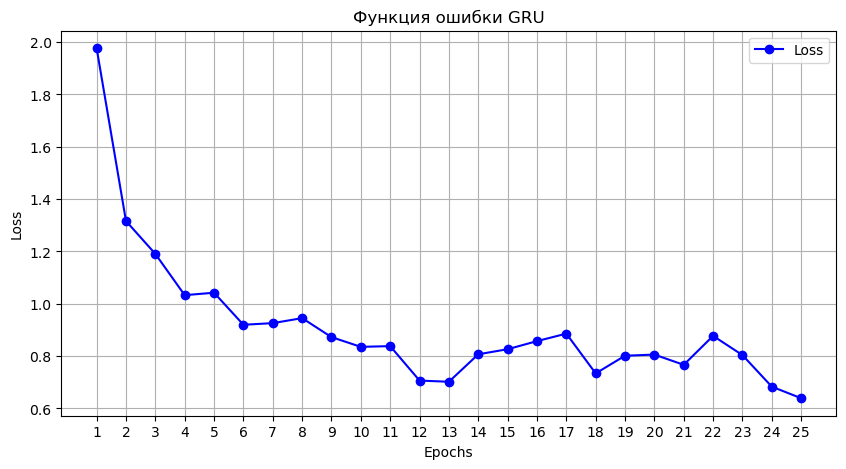

In [186]:
import matplotlib.pyplot as plt

epochs = range(1, len(lossesGRU2) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, lossesGRU2, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Функция ошибки GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.legend()
plt.show()

In [187]:
samples = []

for i in range(5):
    sample = batch_decode(generate(modelGRU2, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), cls=torch.full(size=(20, 1), fill_value=i, dtype=int), max_new_tokens=150))
    samples.append(sample)

for i in range(5):
    count = 0
    for j in range(20):
        if get_sequence_score(samples[i][j]) >= 0.55:
            count += 1
    print(f"{count} антител вида {SPECIES_[i]} имеют оценку более 0.55")

13 антител вида Camel имеют оценку более 0.55
15 антител вида Human имеют оценку более 0.55
17 антител вида Mouse имеют оценку более 0.55
16 антител вида Rabbit имеют оценку более 0.55
18 антител вида Rhesus имеют оценку более 0.55
